In [4]:
%%time

import xarray as xr
import matplotlib.pyplot as plt
import cartopy as cp
from cartopy import crs, feature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import numpy as np
import pymannkendall as mk
# from cdo import *
import warnings
warnings.filterwarnings('ignore')
# cdo = Cdo()

path1='/media/kenz/1B8D1A637BBA134B/CHIRTS'

def set_fig_params(axes):
    for i,j in enumerate(axes):
    # for i in (range(0,len(axes))):
        ax[i].set_extent([-19,15,4,24])
        ax[i].add_feature(feature.COASTLINE)
        ax[i].add_feature(feature.BORDERS)
        ax[i].add_feature(feature.STATES, linewidth = 0.2)
        ax[i].set_xticks([-20,-10,0,10], crs=crs.PlateCarree())
        ax[i].set_yticks([5,10,15,20], crs=crs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax[i].xaxis.set_major_formatter(lon_formatter)
        ax[i].yaxis.set_major_formatter(lat_formatter)

        
def sens_slope(data):
    data = data.groupby('time.year').mean('time')
    data = data.sel(longitude=np.arange(-19.875, 21.875,0.25), latitude=np.arange(3.125,26.875,0.25), method = 'nearest')
    output=[]
    for i in np.arange(len(data.latitude.values)):
        for j in np.arange(len(data.longitude.values)):
            try:
                slope_val = mk.sens_slope(data[:,i,j]).slope
            except:
                slope_val = np.nan
            output.append(slope_val)

    output = np.copy(output).reshape(data.latitude.size,data.longitude.size)
    slopes=xr.DataArray(output, dims=('latitude','longitude'), coords={'latitude':data.latitude,'longitude':data.longitude})
    return slopes

def rising_filter(array, axis):

    # Make sure there are enough points
    assert(array.shape[axis] == 5)
    # Make sure we're working on the last axis
    assert(axis == array.ndim-1 or axis == -1)
    
    left = array[..., 1]
    right = array[..., 2:].sum(axis=axis)

    return np.logical_and(np.isnan(left), np.isfinite(right))

def rising_filter_dask(x, dim):

    return xr.apply_ufunc(rising_filter, x, input_core_dims=[[dim]],
                             kwargs={'axis': -1},
                             dask='parallelized',
                             output_dtypes=[bool])
def HWD(data):
    s = data>0
    s = s.drop_duplicates('time')
    candidates = tx.where(s)
    windows = candidates.chunk({'time':20}).rolling(time=5, center=True, min_periods=1).construct('rolling_dim')
    heatwave_starts = rising_filter_dask(windows, dim='rolling_dim')
    return heatwave_starts

CPU times: user 176 ms, sys: 7.56 ms, total: 183 ms
Wall time: 212 ms


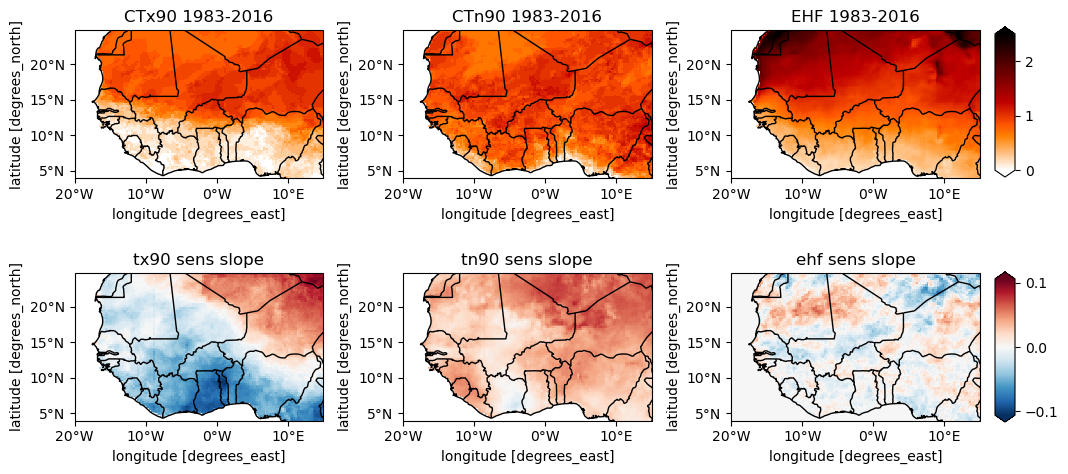

CPU times: user 51 s, sys: 3.09 s, total: 54.1 s
Wall time: 55.4 s


In [2]:
%%time

# Create subplots
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(10, 5), subplot_kw={'projection': crs.PlateCarree()})
ax = ax.flatten()
set_fig_params(ax)

# Load and process data
tx90 = xr.open_dataset(f'{path1}/Tmax/chirts.Tmax90.1983.2016.WA.days_p25.nc').Tmax.sortby('time').drop_duplicates('time')
tx = xr.open_dataset(f'{path1}/Tmax/chirts.Tmax.1983.2016.WA.days_p25.nc').Tmax.sortby('time').drop_duplicates('time')
mask = tx > tx90
ctx90 = tx.where(mask)

tn90 = xr.open_dataset(f'{path1}/Tmin/chirts.Tmin90.1983.2016.WA.days_p25.nc').Tmin.sortby('time').drop_duplicates('time')
tn = xr.open_dataset(f'{path1}/Tmin/chirts.Tmin.1983.2016.WA.days_p25.nc').Tmin.sortby('time').drop_duplicates('time')
mask = tn > tn90
ctn90 = tn.where(mask)

EHF = xr.open_dataset('scripts/EHF.nc')

# Plot your data
cc = 'gist_heat_r'
ctx90 = ctx90.groupby('time.year').count('time').mean('year').plot(ax=ax[0], vmax=2.5, cmap=cc, add_colorbar=False)
ax[0].set_title('CTx90 1983-2016')

cc = 'gist_heat_r'
ctn90 = ctn90.groupby('time.year').count('time').mean('year').plot(ax=ax[1], vmax=2.5, cmap=cc, add_colorbar=False)
ax[1].set_title('CTn90 1983-2016')

cb1 = abs(EHF.Tmax.mean('time')).plot(ax=ax[2], cmap=cc, vmax=2.5, add_colorbar=False)
ax[2].set_title('EHF 1983-2016')

cm = 'RdBu_r'
tx90_s = sens_slope(tx90)
tx90_s.plot(ax=ax[3], cmap=cm, add_colorbar=False)
ax[3].set_title('tx90 sens slope')

tn90_s = sens_slope(tn90)
cb2 = tn90_s.plot(ax=ax[4], cmap=cm, add_colorbar=False)
ax[4].set_title('tn90 sens slope')

ehf_s = sens_slope(EHF.Tmax)
ehf_s.plot(ax=ax[5], cmap=cm, add_colorbar=False)
ax[5].set_title('ehf sens slope')

cb = [cb1, cb2]

# Add colorbars
for i, j in enumerate([0.62, 0.13]):
    cax = fig.add_axes([1, j, 0.02, 0.3])
    fig.colorbar(cb[i], cax=cax, orientation='vertical', extend='both')

fig.tight_layout()
# plt.savefig(path1+'/figures/graph1.jpeg', bbox_inches='tight')
plt.show()  # Use plt.show() to display the plot


CPU times: user 1min 34s, sys: 12.5 s, total: 1min 47s
Wall time: 1min 30s


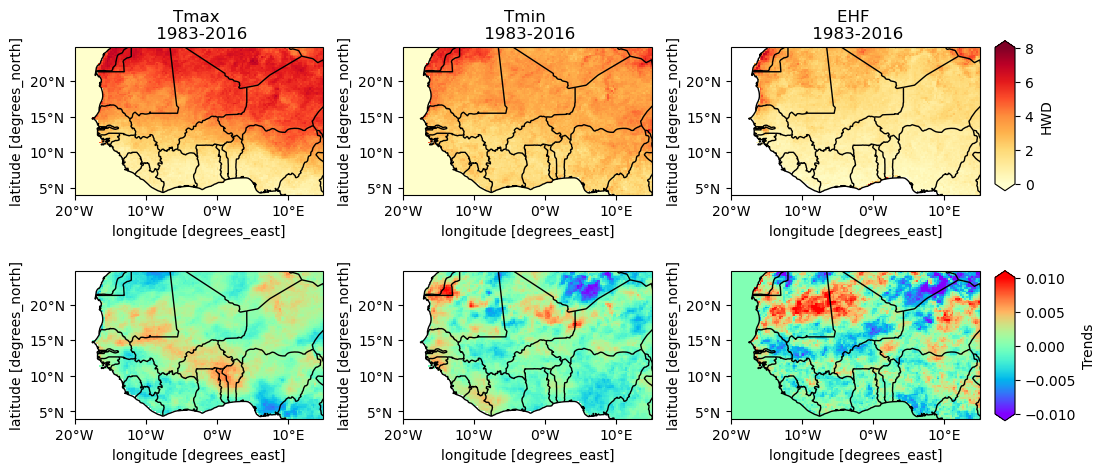

In [36]:
%%time

# Load and process your data
tx = xr.open_dataset(f'{path1}/Tmax/chirts.Tmax.1983.2016.WA.days_p25.nc').Tmax.sortby('time').drop_duplicates('time').chunk({'time': 20})
tn = xr.open_dataset(f'{path1}/Tmin/chirts.Tmin.1983.2016.WA.days_p25.nc').Tmin.sortby('time').drop_duplicates('time').chunk({'time': 20})

# Create subplots
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(10, 5), subplot_kw={'projection': crs.PlateCarree()})
ax = ax.flatten()
set_fig_params(ax)
vmax = 8
vmax1 = 0.01
vmin1 = -0.01

cm = 'YlOrRd'
cc = 'rainbow'
# Calculate and plot Tmax
mask = xr.open_dataset('Tmax/tx-tx90.nc').Tmax
sens_slope(mask).plot(ax=ax[3], cmap=cc, add_colorbar=False, vmax = vmax1, vmin=vmin1)
mask = mask.chunk({'time': 20})
mask = HWD(mask)
cb1 = (mask.sel(time=slice('1983', '2016')).sum('time') / 30).plot(ax=ax[0], cmap=cm, add_colorbar=False, vmax=vmax)
ax[0].set_title('Tmax \n 1983-2016')

# Calculate and plot Tmin
mask = xr.open_dataset('Tmin/tn-tn90.nc').Tmin
sens_slope(mask).plot(ax=ax[4], cmap=cc, add_colorbar=False, vmax = vmax1, vmin=vmin1)
mask = mask.chunk({'time': 20})
mask = HWD(mask)
(mask.sel(time=slice('1983', '2016')).sum('time') / 30).plot(ax=ax[1], cmap=cm, add_colorbar=False, vmax=vmax)
ax[1].set_title('Tmin \n 1983-2016')

# Calculate and plot EHF
mask = xr.open_dataset('scripts/EHF.nc').sortby('time').drop('time_bnds').Tmax
cb2 = sens_slope(mask).plot(ax=ax[5], cmap=cc, add_colorbar=False, vmax = vmax1, vmin = vmin1)
mask = mask.where(mask > 0, drop=True)
mask = mask.rolling(time=3).sum()
(mask.sel(time=slice('1983', '2016')).mean('time')).plot(ax=ax[2], cmap=cm, add_colorbar=False, vmax=vmax)
ax[2].set_title('EHF \n 1983-2016')

# ax[3].set_title('EHF \n 1983-2016')
# ax[4].set_title('EHF \n 1983-2016')
# ax[5].set_title('EHF \n 1983-2016')



# Add colorbar
cb = [cb1, cb2]
labels = ['HWD','Trends']
# Add colorbars
for i, j in enumerate([0.59, 0.13]):
    cax = fig.add_axes([1, j, 0.02, 0.3])
    fig.colorbar(cb[i], cax=cax, orientation='vertical', extend='both', label=labels[i])
    
# cax = fig.add_axes([1, 0.35, 0.02, 0.3])
# fig.colorbar(cb, cax=cax, orientation='vertical', extend='both', label='HWD')

fig.tight_layout()
plt.savefig(path1+'/figures/graph2.jpeg', bbox_inches='tight')
# plt.show()  # Use plt.show() to display the plot